## Predicting the number of variants in contact sets

In [1]:
# increase cell width to use all browser space
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# data and figure directories
data_dir = 'C:/Users/Bian/OneDrive/Research/projects/cosmis/data/'
figure_dir = 'C:/Users/Bian/OneDrive/Research/projects/cosmis/figures/'

In [6]:
import numpy as np
import pandas as pd
import os

# load data set
data = pd.read_csv(
    filepath_or_buffer=os.path.join(data_dir, 'contact_set_features_8a.tsv'), 
    sep='\t',
    header=0
)

# take a look at the top rows to see if the parsing look right
data.head()

,enst_id,ensp_id,uniprot_id,ensp_pos,ensp_aa,pdb_pos,pdb_aa,pdb_id,chain_id,seq_separation,num_contacts,gc_count,cg_count,gc_content,syn_prob,mis_prob,syn_count_obs,mis_count_obs,syn_count_pos,mis_count_pos
0,ENST00000000233,ENSP00000000233,P84085,8,L,8,L,2b6h,A,-1;4;159;1;30;3;2,8,5,5,0.575,5.881000e-07,8.626000e-07,1,1,48,48
1,ENST00000000233,ENSP00000000233,P84085,9,F,9,F,2b6h,A,2;-2;30;28;161;3;1;-1;29;52;158,12,5,5,0.550,7.302000e-07,1.045000e-06,4,1,72,72
2,ENST00000000233,ENSP00000000233,P84085,10,S,10,S,2b6h,A,2;1;51;28;-4;29;-3;-5;48;-1;49;-2,13,6,5,0.508,4.492000e-07,1.045000e-06,2,1,70,70
3,ENST00000000233,ENSP00000000233,P84085,11,R,11,R,2b6h,A,-1;-2;3;1;-5;-3;2,8,5,3,0.600,5.388000e-07,1.092000e-06,0,1,46,46
4,ENST00000000233,ENSP00000000233,P84085,12,I,12,I,2b6h,A,-2;-4;159;-1;155;-3;1;2;158;162,11,5,3,0.600,8.760000e-07,1.296000e-06,1,1,73,73


In [7]:
# remove ID columns from the data set
data_id_removed = data.iloc[:, 10:]

# remove contact sets that have less than 8 residues
# data_id_removed = data_id_removed[data_id_removed['num_contacts'] >= 15]
data_id_removed.head()

,num_contacts,gc_count,cg_count,gc_content,syn_prob,mis_prob,syn_count_obs,mis_count_obs,syn_count_pos,mis_count_pos
0,8,5,5,0.575,5.881000e-07,8.626000e-07,1,1,48,48
1,12,5,5,0.550,7.302000e-07,1.045000e-06,4,1,72,72
2,13,6,5,0.508,4.492000e-07,1.045000e-06,2,1,70,70
3,8,5,3,0.600,5.388000e-07,1.092000e-06,0,1,46,46
4,11,5,3,0.600,8.760000e-07,1.296000e-06,1,1,73,73


### Creating Data Sets for Training, Validation, and Testing
The data set was split into training, validation, and testing subsets with ```[0.8, 0.1, 0.1]``` ratio. 

In [8]:
# create a training set and a test set
shuffled_indices = np.random.permutation(len(data_id_removed))
train_size = int(len(data_id_removed) * 0.8)
val_size = int(len(data_id_removed) * 0.1)
train_indices = shuffled_indices[:train_size]
val_indices = shuffled_indices[train_size:(train_size + val_size)]
test_indices = shuffled_indices[(train_size + val_size):]
train_data = data_id_removed.iloc[train_indices]
val_data = data_id_removed.iloc[val_indices]
test_data = data_id_removed.iloc[test_indices]

# get data matrices for training and testing
feature_column_ids = [0, 1, 2, 3, 4, 8]
X_train = train_data.iloc[:, feature_column_ids]
y_train = train_data.iloc[:, 6]
X_val = val_data.iloc[:, feature_column_ids]
y_val = val_data.iloc[:, 6]
X_test = test_data.iloc[:, feature_column_ids]
y_test = test_data.iloc[:, 6]

### Training models
#### Gradient Boosted Regression Tree Model

In [10]:
# fit a gradient boosting regressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

scaling_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])
X_train_scaled = scaling_pipeline.fit_transform(X_train)
X_val_scaled = scaling_pipeline.fit_transform(X_val)

gbrt = GradientBoostingRegressor(max_depth=5, warm_start=True)

min_val_error = float('inf')
error_going_up = 0
for n_estimators in range(1, 100):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train_scaled, y_train)
    y_pred_val = gbrt.predict(X_val_scaled)
    val_error = mean_squared_error(y_val, y_pred_val)
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        if error_going_up == 5:
            # early stopping
            break

In [18]:
gbrt.get_params()

{'alpha': 0.9,
 'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'ls',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 74,
 'n_iter_no_change': None,
 'presort': 'deprecated',
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': True}

#### Feature Importance
In decision trees, important features are more likely to appear closer to the root of the tree, while unimportant features will often appear closer to the leaves. It is therefore possible to get an estimate of a feature's importance by computing the average depth at which it appears cross all three in the model.Scikit-Learn computes this automatically for every feature after training. We can access the result using the ```feature_importance_``` attribute of the trained model.

In [11]:
# print out feature importance scores
for name, score in zip(X_train.columns, gbrt.feature_importances_):
    print(name + ':', '%.3f' % score)

num_contacts: 0.081
gc_count: 0.002
cg_count: 0.001
gc_content: 0.008
syn_prob: 0.903
syn_count_pos: 0.003


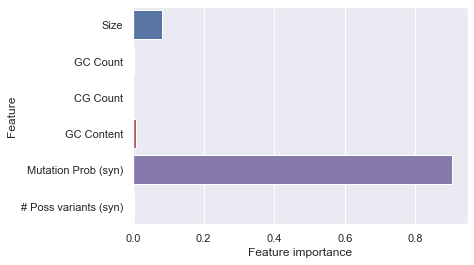

In [12]:
# plot feature importance score
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme()
ax = sns.barplot(
    y=['Size', 'GC Count', 'CG Count', 'GC Content', 
       'Mutation Prob (syn)', '# Poss variants (syn)'], 
    x=gbrt.feature_importances_
)
ax.set(xlabel='Feature importance', ylabel='Feature')
plt.show()

In [14]:
# Pearson's r
from scipy.stats import pearsonr

X_test_scaled = scaling_pipeline.fit_transform(X_test)
y_pred = gbrt.predict(X_test_scaled)

# r = 0.598
pearsonr(y_test, y_pred)

(0.5978367188821693, 0.0)

[Text(0.5, 0, 'Predicted number of syn. variants'),
 Text(0, 0.5, 'Observed number of syn. variants')]

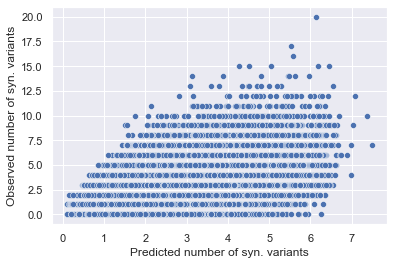

In [17]:
ax = sns.scatterplot(x=y_pred, y=y_test)
ax.set(xlabel='Predicted number of syn. variants', ylabel='Observed number of syn. variants')

#### Fitting a simple linear regression model

In [39]:
#
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
X_combined = np.concatenate((X_train_scaled, X_val_scaled))
y_combined = np.concatenate(((y_train, y_val)))
lr.fit(X_combined[:, 4].reshape(-1, 1), y_combined)

#
y_pred = lr.predict(X_test_scaled[:, 4].reshape(-1, 1))
pearsonr(y_test, y_pred)

(0.5524878350007173, 0.0)

[Text(0.5, 0, 'Predicted number of syn. variants'),
 Text(0, 0.5, 'Observed number of syn. variants')]

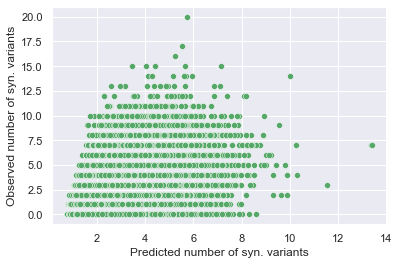

In [40]:
# plot predictions vs observations
ax = sns.scatterplot(x=y_pred, y=y_test, color='g')
ax.set(xlabel='Predicted number of syn. variants', ylabel='Observed number of syn. variants')

#### Fitting a multivariate linear regression model

In [41]:
lr = LinearRegression()
X_combined = np.concatenate((X_train_scaled, X_val_scaled))
y_combined = np.concatenate(((y_train, y_val)))
lr.fit(X_combined, y_combined)

#
y_pred = lr.predict(X_test_scaled)
pearsonr(y_test, y_pred)

(0.5872740561789709, 0.0)

[Text(0.5, 0, 'Predicted number of syn. variants'),
 Text(0, 0.5, 'Observed number of syn. variants')]

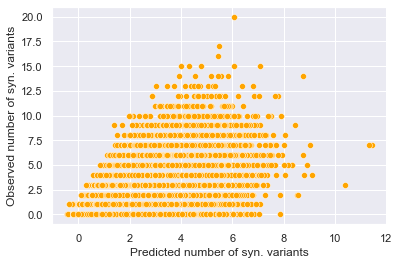

In [43]:
# plot predictions vs observations
ax = sns.scatterplot(x=y_pred, y=y_test, color='orange')
ax.set(xlabel='Predicted number of syn. variants', ylabel='Observed number of syn. variants')

#### Linear Support Vector Regression Model

In [22]:
# import required modules
from sklearn.svm import LinearSVR

val_error = []
for e in np.arange(0.1, 1.5, 0.1):
    svm_reg = LinearSVR(epsilon=e)
    svm_reg.fit(X_train_scaled, y_train)
    y_pred_val = svm_reg.predict(X_val_scaled)
    val_error.append(mean_squared_error(y_val, y_pred_val))

In [31]:
pd.DataFrame({'epsilon': np.arange(0.1, 1.5, 0.1), 'validation error': val_error})

,epsilon,validation error
0,0.1,2.174865
1,0.2,2.174460
2,0.3,2.174111
3,0.4,2.171015
4,0.5,2.169012
5,0.6,2.167279
6,0.7,2.165581
7,0.8,2.163637
8,0.9,2.162261
9,1.0,2.159302


In [30]:
svm_reg = LinearSVR(epsilon=1.2)
svm_reg.fit(np.concatenate((X_train_scaled, X_val_scaled)), np.concatenate((y_train, y_val)))
y_pred = svm_reg.predict(X_test_scaled)
pearsonr(y_test, y_pred)

(0.586636609706563, 0.0)

[Text(0.5, 0, 'Predicted number of syn. variants'),
 Text(0, 0.5, 'Observed number of syn. variants')]

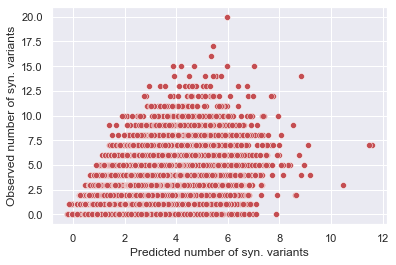

In [33]:
# plot predictions vs observations
ax = sns.scatterplot(x=y_pred, y=y_test, color='r')
ax.set(xlabel='Predicted number of syn. variants', ylabel='Observed number of syn. variants')

In [ ]:
# import required module(s)
from sklearn.svm import SVR

svm_poly_reg = SVR(kernel='poly', degree=2, C=100, epsilon=0.1)
svm_poly_reg.fit(X_train_scaled, y_train)